=== Best Isolation Forest Params ===
{'bootstrap': True, 'max_features': 0.8, 'max_samples': 1.0, 'n_estimators': 50}
Initial Coarse Thresholds: crit=-0.1534, warn=-0.1270

=== Optimized Thresholds (Critical & Warning) ===
Critical threshold: -0.1481
Warning  threshold: -0.1109
Combined Score    : 0.3667
F1 (Critical)     : 0.4000
F1 (Warning)      : 0.3333

Classification Report:
               precision    recall  f1-score   support

    Critical       0.30      0.59      0.40        17
     Warning       0.25      0.52      0.33        31
      Normal       1.00      0.99      0.99      6473

    accuracy                           0.99      6521
   macro avg       0.52      0.70      0.58      6521
weighted avg       0.99      0.99      0.99      6521



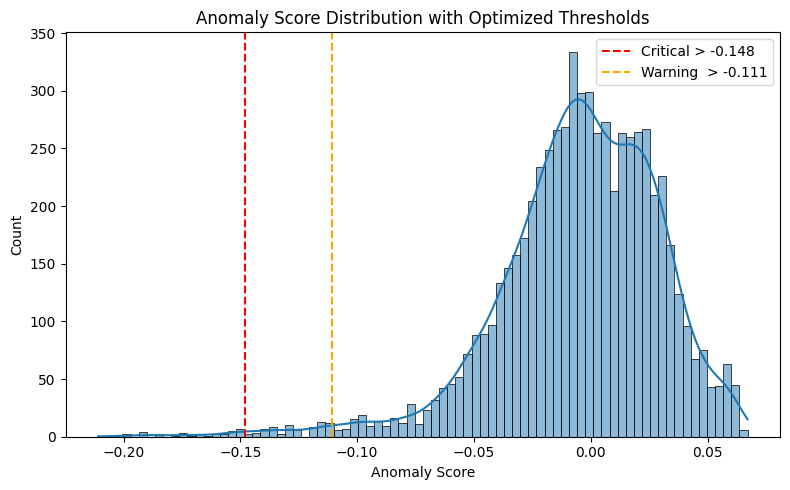

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score
from joblib import dump
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

# --- 1. โหลดข้อมูลและเตรียม Label ---
# (a) ข้อมูลสำหรับ Validation มี label พร้อม
df_val = pd.concat([
    pd.read_csv("./data/dev101_resample10T.csv"),
    pd.read_csv("./data/dev102_resample10T.csv")
], ignore_index=True)

# เปลี่ยนชื่อคอลัมน์ ให้ง่ายขึ้น
df_val.rename(columns={
    'soil_mean':'soil', 'rain_mean':'rain',
    'temp_mean':'temp', 'humi_mean':'humi', 'geo_mean':'geo'
}, inplace=True)

# เติม label ที่หายไป และ normalize ชื่อ
df_val['label'] = df_val['label'].fillna('Normal').replace({
    'critical':'Critical','warning':'Warning',
    'normal':'Normal','Normal':'Normal'
})

# --- 2. โหลดข้อมูล Train (unlabeled) และแยกเป็น train/test ---
df_train_full = pd.concat([
    pd.read_csv("./data/dev101_prepared.csv"),
    pd.read_csv("./data/dev102_prepared.csv")
], ignore_index=True)
# ถ้ามี lat/lng ให้ drop
for c in ['lat','lng']:
    if c in df_train_full.columns:
        df_train_full.drop(columns=[c], inplace=True)

# แยก train / temp / test
df_train, df_temp = train_test_split(
    df_train_full, test_size=0.2, random_state=42)
_, df_test = train_test_split(
    df_temp, test_size=0.35, random_state=42)

# Features กับ Label
FEATURE_COLS = ['soil','rain','temp','humi','geo']
X_train = df_train[FEATURE_COLS].values
X_val   = df_val[FEATURE_COLS].values
y_val   = df_val['label'].values

# --- 3. Scale features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# --- 4. Grid Search หาโมเดล Isolation Forest ที่ดีที่สุด (coarse) ---
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_samples': [0.6, 0.8, 1.0],
    'max_features': [0.6, 0.8, 1.0],
    'bootstrap': [False, True]
}
grid = list(ParameterGrid(param_grid))
CONTAMINATION = 0.5

best_model = {'score': -np.inf}
for params in grid:
    iso = IsolationForest(
        contamination=CONTAMINATION,
        random_state=42,
        **params
    )
    iso.fit(X_train_scaled)
    # ใช้ val_scores ในการหา threshold ขั้นแรก
    val_scores = iso.decision_function(X_val_scaled)
    
    # สุ่ม candidate thresholds จาก percentiles
    ct_vals = np.percentile(val_scores, np.linspace(0.01, 0.45, 30))
    wt_vals = np.percentile(val_scores, np.linspace(0.40, 1, 30))
    
    for ct in ct_vals:
        for wt in wt_vals:
            if wt <= ct:
                continue
            # classify
            preds = np.where(val_scores < ct, 'Critical',
                     np.where(val_scores < wt, 'Warning', 'Normal'))
            # คำนวณ F1 per class
            labels = ['Critical','Warning','Normal']
            f1s = f1_score(y_val, preds, labels=labels, average=None, zero_division=0)
            # เอาเฉพาะ Critical + Warning มาคิด score
            score = 0.5 * f1s[0] + 0.5 * f1s[1]
            if score > best_model['score']:
                best_model.update({
                    'score': score,
                    'params': params,
                    'crit': ct,
                    'warn': wt,
                    'model': iso,
                    'val_scores': val_scores,
                    'f1s': f1s
                })

# --- 5. Fine-tune Threshold (ละเอียด) บนโมเดลที่เลือกแล้ว ---
val_scores = best_model['val_scores']
cands = np.percentile(val_scores, np.arange(0, 10, 0.5))

best_thresh = {'score': -np.inf}
for ct in cands:
    for wt in cands:
        if wt <= ct: continue
        preds = np.where(val_scores < ct, 'Critical',
                 np.where(val_scores < wt, 'Warning', 'Normal'))
        # F1 per class
        labels = ['Critical','Warning','Normal']
        f1s = f1_score(y_val, preds, labels=labels, average=None, zero_division=0)
        # เน้น 2 คลาส
        score = 0.5 * f1s[0] + 0.5 * f1s[1]
        if score > best_thresh['score']:
            best_thresh.update({
                'score': score,
                'crit': ct,
                'warn': wt,
                'f1s': f1s,
                'report': classification_report(y_val, preds, labels=labels)
            })

# --- 6. บันทึกโมเดล + Scaler ---
dump(best_model['model'], './model/iso_best_model.joblib')
dump(scaler, './model/iso_best_scaler.joblib')

# --- 7. แสดงผลสรุป ---
print("=== Best Isolation Forest Params ===")
print(best_model['params'])
print(f"Initial Coarse Thresholds: crit={best_model['crit']:.4f}, warn={best_model['warn']:.4f}")
print("\n=== Optimized Thresholds (Critical & Warning) ===")
print(f"Critical threshold: {best_thresh['crit']:.4f}")
print(f"Warning  threshold: {best_thresh['warn']:.4f}")
print(f"Combined Score    : {best_thresh['score']:.4f}")
print(f"F1 (Critical)     : {best_thresh['f1s'][0]:.4f}")
print(f"F1 (Warning)      : {best_thresh['f1s'][1]:.4f}")
print("\nClassification Report:\n", best_thresh['report'])

# --- 8. Plot Distribution & Thresholds ---
plt.figure(figsize=(8,5))
sns.histplot(val_scores, bins=80, kde=True)
plt.axvline(best_thresh['crit'], color='red',   linestyle='--', label=f'Critical > {best_thresh["crit"]:.3f}')
plt.axvline(best_thresh['warn'], color='orange',linestyle='--', label=f'Warning  > {best_thresh["warn"]:.3f}')
plt.title("Anomaly Score Distribution with Optimized Thresholds")
plt.xlabel("Anomaly Score")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()
